In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

--2025-07-02 07:16:58--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.04s   

2025-07-02 07:16:58 (6.14 MB/s) - ‘names.txt’ saved [228145/228145]



In [5]:
words=open('names.txt','r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [6]:
chars=sorted(list(set(''.join(words))))
stoi={s:i+1  for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [7]:
# utility function we will use later when comparing manual gradients to Pytorch gradients

def cmp(s,dt,t):
  ex=torch.all(dt==t.grad).item()
  app=torch.allclose(dt,t.grad)
  maxdiff=(dt-t.grad).abs().max().item()
  print(f'{s:15s} |  exact:{str(ex):5s} | Approximate:{str(app):5s} | maxdiff:{maxdiff}')

In [8]:
# training split , dev/validation split , test split
# 80% , 10% , 10%

block_size=3 # context length , how many characters  do we take to predict the next one
def build_dataset(words):
  #build the dataset
  X,Y = [],[]

  for w in words:
    context=block_size*[0]
    for ch in w + ".":
      ix=stoi[ch]
      X.append(context)
      Y.append(ix)

      context=context[1:]+[ix]

  X=torch.tensor(X)
  Y=torch.tensor(Y)

  print(X.shape,Y.shape)
  return X,Y

import random
random.seed(42)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

Xtr,Ytr=build_dataset(words[:n1])
Xdev,Ydev=build_dataset(words[n1:n2])
Xte,Yte=build_dataset(words[n2:])


torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [9]:
n_embed=10 # the dimensionality of the character embedding vectors
n_hidden=200 # the number of neurons in the hidden layer of the MLP

g=torch.Generator().manual_seed(2147483647) # for reproducibility
C=torch.randn((vocab_size,n_embed),generator=g)


#Layer 1
W1=torch.randn((n_embed*block_size,n_hidden),generator=g) * (5/3)/((n_embed*block_size)**0.5)
b1=torch.randn(n_hidden,generator=g) * 0.1


#Layer 2
W2=torch.randn((n_hidden,vocab_size),generator=g) * 0.1
b2=torch.randn(vocab_size , generator=g) * 0.1


#BATCH NORM PARAMETERS

bngain=torch.ones((1,n_hidden)) * 0.1 + 1.0
bnbias=torch.zeros((1,n_hidden)) * 0.1


bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))

parameters=[C,W1,b1,W2,b2,bngain,bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad=True


12297


In [10]:
batch_size=32
n=batch_size # shorter variable for convenience

ix=torch.randint(0,Xtr.shape[0],(batch_size,), generator=g)
Xb, Yb= Xtr[ix], Ytr[ix]  #batch X,Y

In [11]:
#forward pass

emb=C[Xb]  # embed the characters into vectors
embcat=emb.view(emb.shape[0],-1) # concatenate the vectors

#Linear layer 1
hprebn=embcat@W1+b1 # hidden layer pre-activation

#Batch Norm Layer
bnmeani=(1/n)*hprebn.sum(0,keepdim=True)
bndiff=hprebn-bnmeani
bndiff2=bndiff**2
bnvar=(1/(n-1))*(bndiff2).sum(0,keepdim=True)  #(note: Bessel's correction dividing by n-1 not n)
bnvar_inv=(bnvar+1e-5)**(-0.5)
bnraw=bndiff*bnvar_inv
hpreact=bngain*bnraw+bnbias


#Non-Linearity
h=torch.tanh(hpreact) # hidden layer

#Linear layer 2
logits=h@W2+b2


#Cross entropy (same as F.cross_entropy(logits,Yb))

logit_maxes=logits.max(1,keepdim=True).values
norm_logits=logits-logit_maxes  # subtract max for numerical stability
counts=norm_logits.exp()
counts_sum=counts.sum(1,keepdim=True)
counts_sum_inv=counts_sum**(-1)
probs=counts*counts_sum_inv

logprobs=probs.log()
loss=-logprobs[range(n),Yb].mean()


#pytorch backward pass
for p in parameters:
  p.grad=None


for t in [logprobs,probs,counts,counts_sum,counts_sum_inv,norm_logits,
          logit_maxes,logits,h,hpreact,bnraw,bnvar_inv,bnvar,bndiff2,bndiff,hprebn,
          bnmeani,embcat,emb]:
          t.retain_grad()


loss.backward()
loss

tensor(4.1375, grad_fn=<NegBackward0>)

In [12]:
bndiff.shape,hprebn.shape,bnmeani.shape

(torch.Size([32, 200]), torch.Size([32, 200]), torch.Size([1, 200]))

In [13]:
counts.shape,counts_sum_inv.shape, probs.shape

(torch.Size([32, 27]), torch.Size([32, 1]), torch.Size([32, 27]))

In [14]:
"""
a11 a12 a13         b1
a21 a22 a23 ---->   b2
a31 a32 a33         b3
"""
logits.shape , logit_maxes.shape

(torch.Size([32, 27]), torch.Size([32, 1]))

In [15]:
W2.shape , h .shape

(torch.Size([200, 27]), torch.Size([32, 200]))

In [16]:
"""
c = a * b , but with tensors
a[3*3] * b[3*1] --->
a11*b1 , a12 * b1 , a13 * b1
a21*b2 , a22 * b2 , a23 * b2
a31*b3 , a32 * b3 , a33 * b3

c[3*3]

BROADCASTING OPERATION
"""


'\nc = a * b , but with tensors\na[3*3] * b[3*1] --->\na11*b1 , a12 * b1 , a13 * b1\na21*b2 , a22 * b2 , a23 * b2\na31*b3 , a32 * b3 , a33 * b3\n\nc[3*3]\n\nBROADCASTING OPERATION\n'

In [17]:
emb.shape,C.shape,Xb.shape

(torch.Size([32, 3, 10]), torch.Size([27, 10]), torch.Size([32, 3]))

In [18]:
emb.shape,embcat.shape

(torch.Size([32, 3, 10]), torch.Size([32, 30]))

In [19]:
bnraw.shape, bndiff.shape, bnvar_inv.shape

(torch.Size([32, 200]), torch.Size([32, 200]), torch.Size([1, 200]))

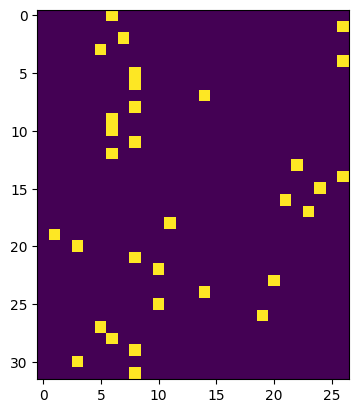

In [20]:
plt.imshow(F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]) )

In [21]:
"""
just for convenice writing dlogprobs as (dloss/dlogprobs)
"""


"""
 loss = -(a+b+c)/3
dloss/da=-(1/3)
dloss/db=-(1/3)
dloss/dc=-(1/3)
"""



"""
dloss/dprobs= (dloss/dlogprobs) * (dlogprobs*dprobs)

dlogprobs= (1/probs) * dprobs


"""
dlogprobs= torch.zeros_like(logprobs)
dlogprobs[range(n),Yb]=-1.0/n

dprobs= dlogprobs * (1.0/probs)


dcounts_sum_inv=(dprobs*counts).sum(1,keepdim=True)


dcounts= dprobs*counts_sum_inv

dcounts_sum= dcounts_sum_inv * -(counts_sum**-2)

dcounts+=torch.ones_like(counts)*dcounts_sum

dnorm_logits=(norm_logits).exp() * dcounts

dlogits= 1.0 * dnorm_logits

dlogit_maxes=(-1.0*dnorm_logits).sum(1,keepdim=True)

dlogits+=F.one_hot(logits.max(1).indices,num_classes=logits.shape[1]) * dlogit_maxes

dh=dlogits @ W2.T

dW2= h.T @ dlogits

db2= dlogits.sum(0)

dhpreact= dh * (1.0- h**2)

dbngain=(dhpreact*bnraw).sum(0,keepdim=True)
dbnraw=dhpreact*bngain
dbnbias=dhpreact.sum(0,keepdim=True)

dbndiff=bnvar_inv*dbnraw

dbnvar_inv=(bndiff*dbnraw).sum(0,keepdim=True)

dbnvar=dbnvar_inv*(-0.5*(bnvar+1e-5)**(-1.5))


dbndiff2=(1.0/(n-1))*torch.ones_like(bndiff2)*dbnvar

dbndiff+=2*bndiff*dbndiff2

dhprebn=dbndiff*1.0

dbnmeani= (-1.0*dbndiff).sum(0,keepdim=True)

dhprebn+=(1.0/n)*torch.ones_like(hprebn)*dbnmeani

dembcat= dhprebn @ W1.T

dW1= embcat.T @ dhprebn

db1=dhprebn.sum(0)

demb=dembcat.view(emb.shape)

dC= torch.zeros_like(C)

for i in range(Xb.shape[0]):
  for j in range(Xb.shape[1]):
    ix=Xb[i,j]
    dC[ix]+=demb[i,j]


cmp('dlogprobs',dlogprobs,logprobs)
cmp('dprobs',dprobs,probs)
cmp('dcounts_sum_inv',dcounts_sum_inv,counts_sum_inv)
cmp('dcounts_sum',dcounts_sum,counts_sum)
cmp('dcounts',dcounts,counts)
cmp('dnorm_logits',dnorm_logits,norm_logits)
cmp('logit_maxes',dlogit_maxes,logit_maxes)
cmp('logits',dlogits,logits)
cmp('h',dh,h)
cmp('W2',dW2,W2)
cmp('b2',db2,b2)
cmp('hpreact',dhpreact,hpreact)
cmp('bnbias',dbnbias,bnbias)
cmp('bngain',dbngain,bngain)
cmp('bnraw',dbnraw,bnraw)
cmp('bnvar_inv',dbnvar_inv,bnvar_inv)
cmp('bnvar',dbnvar,bnvar)
cmp('bndiff2',dbndiff2,bndiff2)
cmp('bndiff',dbndiff,bndiff)
cmp('bnmeani',dbnmeani,bnmeani)
cmp('hprebn',dhprebn,hprebn)
cmp('embcat',dembcat,embcat)
cmp('W1',dW1,W1)
cmp('b1',db1,b1)
cmp('emb',demb,emb)
cmp('C',dC,C)

dlogprobs       |  exact:True  | Approximate:True  | maxdiff:0.0
dprobs          |  exact:True  | Approximate:True  | maxdiff:0.0
dcounts_sum_inv |  exact:True  | Approximate:True  | maxdiff:0.0
dcounts_sum     |  exact:True  | Approximate:True  | maxdiff:0.0
dcounts         |  exact:True  | Approximate:True  | maxdiff:0.0
dnorm_logits    |  exact:True  | Approximate:True  | maxdiff:0.0
logit_maxes     |  exact:True  | Approximate:True  | maxdiff:0.0
logits          |  exact:True  | Approximate:True  | maxdiff:0.0
h               |  exact:True  | Approximate:True  | maxdiff:0.0
W2              |  exact:True  | Approximate:True  | maxdiff:0.0
b2              |  exact:True  | Approximate:True  | maxdiff:0.0
hpreact         |  exact:False | Approximate:True  | maxdiff:9.313225746154785e-10
bnbias          |  exact:False | Approximate:True  | maxdiff:7.450580596923828e-09
bngain          |  exact:False | Approximate:True  | maxdiff:1.862645149230957e-09
bnraw           |  exact:False | App

In [22]:
bngain.shape, bnraw.shape, dhpreact.shape , bnbias.shape

(torch.Size([1, 200]),
 torch.Size([32, 200]),
 torch.Size([32, 200]),
 torch.Size([1, 200]))

In [23]:
# Exercise 2: backprop through cross_entropy but all in one go
# to complete this challenge look at the mathematical expression of the loss,
# take the derivative, simplify the expression, and just write it out

# forward pass

# before:
# logit_maxes = logits.max(1, keepdim=True).values
# norm_logits = logits - logit_maxes # subtract max for numerical stability
# counts = norm_logits.exp()
# counts_sum = counts.sum(1, keepdims=True)
# counts_sum_inv = counts_sum**-1 # if I use (1.0 / counts_sum) instead then I can't get backprop to be bit exact...
# probs = counts * counts_sum_inv
# logprobs = probs.log()
# loss = -logprobs[range(n), Yb].mean()

# now:
loss_fast = F.cross_entropy(logits, Yb)
print(loss_fast.item(), 'diff:', (loss_fast - loss).item())

4.137534141540527 diff: 4.76837158203125e-07


In [24]:
dlogits=F.softmax(logits,1)
dlogits[range(n),Yb]-=1
dlogits/=n
cmp('logits',dlogits,logits)

logits          |  exact:False | Approximate:True  | maxdiff:5.587935447692871e-09


In [25]:
logits.shape,Yb.shape

(torch.Size([32, 27]), torch.Size([32]))

In [26]:
F.softmax(logits,1)[0]

tensor([0.0077, 0.0418, 0.0209, 0.0069, 0.1033, 0.0765, 0.1834, 0.0429, 0.0071,
        0.0278, 0.0278, 0.0709, 0.0142, 0.0431, 0.0040, 0.0060, 0.0286, 0.0056,
        0.0411, 0.0302, 0.0924, 0.0212, 0.0101, 0.0154, 0.0238, 0.0279, 0.0193],
       grad_fn=<SelectBackward0>)

In [27]:
dlogits[0]

tensor([ 0.0002,  0.0013,  0.0007,  0.0002,  0.0032,  0.0024,  0.0057,  0.0013,
        -0.0310,  0.0009,  0.0009,  0.0022,  0.0004,  0.0013,  0.0001,  0.0002,
         0.0009,  0.0002,  0.0013,  0.0009,  0.0029,  0.0007,  0.0003,  0.0005,
         0.0007,  0.0009,  0.0006], grad_fn=<SelectBackward0>)

In [28]:
"""
sum is very close to zero , because kind of push/pull is happening, the correct probability is being pushed up
while the incorrect probability is being pulled down. This is in effect affects the weights and biases of the network all the way down
to the input layer
"""

dlogits[0].sum()

tensor(-2.3283e-09, grad_fn=<SumBackward0>)

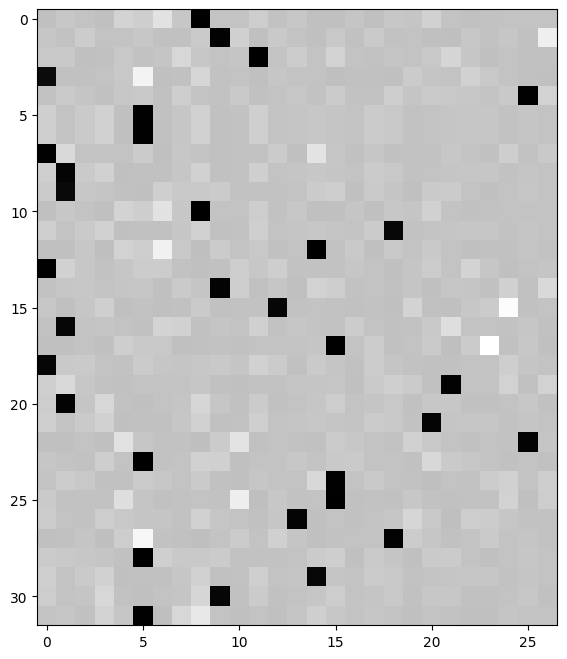

In [29]:
plt.figure(figsize=(8,8))
plt.imshow(dlogits.detach(),cmap='gray')

In [30]:
# Exercise 3: backprop through batchnorm but all in one go
# to complete this challenge look at the mathematical expression of the output of batchnorm,
# take the derivative w.r.t. its input, simplify the expression, and just write it out
# BatchNorm paper: https://arxiv.org/abs/1502.03167

# forward pass

# before:
# bnmeani = 1/n*hprebn.sum(0, keepdim=True)
# bndiff = hprebn - bnmeani
# bndiff2 = bndiff**2
# bnvar = 1/(n-1)*(bndiff2).sum(0, keepdim=True) # note: Bessel's correction (dividing by n-1, not n)
# bnvar_inv = (bnvar + 1e-5)**-0.5
# bnraw = bndiff * bnvar_inv
# hpreact = bngain * bnraw + bnbias

# now:
hpreact_fast = bngain * (hprebn - hprebn.mean(0, keepdim=True)) / torch.sqrt(hprebn.var(0, keepdim=True, unbiased=True) + 1e-5) + bnbias
print('max diff:', (hpreact_fast - hpreact).abs().max())

max diff: tensor(4.7684e-07, grad_fn=<MaxBackward1>)


In [31]:
n

32

In [32]:
dhpreact.shape,dhpreact.sum(0).shape,bnraw.shape

(torch.Size([32, 200]), torch.Size([200]), torch.Size([32, 200]))

In [33]:
bngain.shape,bnvar_inv.shape

(torch.Size([1, 200]), torch.Size([1, 200]))

In [34]:

# backward pass

# before we had:
# dbnraw = bngain * dhpreact
# dbndiff = bnvar_inv * dbnraw
# dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
# dbnvar = (-0.5*(bnvar + 1e-5)**-1.5) * dbnvar_inv
# dbndiff2 = (1.0/(n-1))*torch.ones_like(bndiff2) * dbnvar
# dbndiff += (2*bndiff) * dbndiff2
# dhprebn = dbndiff.clone()
# dbnmeani = (-dbndiff).sum(0)
# dhprebn += 1.0/n * (torch.ones_like(hprebn) * dbnmeani)

# calculate dhprebn given dhpreact (i.e. backprop through the batchnorm)
# (you'll also need to use some of the variables from the forward pass up above)

dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

cmp('hprebn', dhprebn, hprebn) # I can only get approximate to be true, my maxdiff is 9e-10



hprebn          |  exact:False | Approximate:True  | maxdiff:1.3969838619232178e-09


In [35]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.1
# Layer 2
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.1
b2 = torch.randn(vocab_size,                      generator=g) * 0.1
# BatchNorm parameters
bngain = torch.randn((1, n_hidden))*0.1 + 1.0
bnbias = torch.randn((1, n_hidden))*0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f'Number of Parameters:{sum(p.nelement() for p in parameters)}')
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# use this context manager for efficiency once your backward pass is written (TODO)
with torch.no_grad():

# kick off optimization
  for i in range(max_steps):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hprebn = embcat @ W1 + b1 # hidden layer pre-activation
    # BatchNorm layer
    # -------------------------------------------------------------
    bnmean = hprebn.mean(0, keepdim=True)
    bnvar = hprebn.var(0, keepdim=True, unbiased=True)
    bnvar_inv = (bnvar + 1e-5)**-0.5
    bnraw = (hprebn - bnmean) * bnvar_inv
    hpreact = bngain * bnraw + bnbias
    # -------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
      p.grad = None

    # manual backprop!
    dlogits=F.softmax(logits,1)
    dlogits[range(n),Yb]-=1
    dlogits/=n


    # 2nd layer backprop
    dh=dlogits @ W2.T
    dW2= h.T @ dlogits

    db2= dlogits.sum(0)

    #tanh backprop
    dhpreact= dh * (1.0- h**2)

    #batchnorm backprop

    dbngain=(dhpreact*bnraw).sum(0,keepdim=True)
    dbnbias=dhpreact.sum(0,keepdim=True)

    dhprebn = bngain*bnvar_inv/n * (n*dhpreact - dhpreact.sum(0) - n/(n-1)*bnraw*(dhpreact*bnraw).sum(0))

    #1st layer
    dembcat= dhprebn @ W1.T

    dW1= embcat.T @ dhprebn

    db1=dhprebn.sum(0)

    #embedding
    demb=dembcat.view(emb.shape)

    dC= torch.zeros_like(C)

    for k in range(Xb.shape[0]):
      for j in range(Xb.shape[1]):
        ix=Xb[k,j]
        dC[ix]+=demb[k,j]
    # -----------------

    grads = [dC, dW1, db1, dW2, db2, dbngain, dbnbias]

    # -----------------
    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p, grad in zip(parameters, grads):
      p.data+=-lr*grad
      # p.data += -lr * p.grad # old way of cheems doge (using PyTorch grad from .backward())
      #p.data += -lr * grad # new way of swole doge TODO: enable

    # track stats
    if i % 10000 == 0: # print every once in a while
      print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


Number of Parameters:12297
      0/ 200000: 4.0807
  10000/ 200000: 2.0957
  20000/ 200000: 2.0667
  30000/ 200000: 1.7591
  40000/ 200000: 2.0495
  50000/ 200000: 1.9422
  60000/ 200000: 2.6276
  70000/ 200000: 2.3350
  80000/ 200000: 1.8153
  90000/ 200000: 2.2998
 100000/ 200000: 2.1586
 110000/ 200000: 1.9169
 120000/ 200000: 1.9188
 130000/ 200000: 2.0760
 140000/ 200000: 2.0601
 150000/ 200000: 2.3629
 160000/ 200000: 1.9903
 170000/ 200000: 2.1860
 180000/ 200000: 2.2385
 190000/ 200000: 1.7978


In [36]:
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnvar = hpreact.var(0, keepdim=True, unbiased=True)

In [37]:
# evaluate train and val loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0234570503234863
val 2.32807993888855


In [38]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # ------------
      # forward pass:
      # Embedding
      emb = C[torch.tensor([context])] # (1,block_size,d)
      embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
      hpreact = embcat @ W1 + b1
      hpreact = bngain * (hpreact - bnmean) * (bnvar + 1e-5)**-0.5 + bnbias
      h = torch.tanh(hpreact) # (N, n_hidden)
      logits = h @ W2 + b2 # (N, vocab_size)
      # ------------
      # Sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

mora.
mayah.
see.
madhayla.
remman.
emdrlee.
adelynnelin.
shi.
jen.
edelissopharleigh.
malaia.
nosalbergihi.
jest.
jaireth.
konnie.
casuma.
ged.
ryyah.
faeh.
yuma.
